In [1]:
from __future__ import division # backward compatibility for python2
import numpy as np
import pandas as pd
import scipy.special
import operator
import random
#library for plotting arrays

import matplotlib.pyplot as plt
# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.
%matplotlib inline

In [2]:
# datasets to read
# you can change these when trying out other datasets
data_file = "Iris.csv"

class_index = 4 # on inspection of the csv file we see that the class appears in 4th position

In [3]:
def load_dataset(filename, class_idx=class_index, split=0.8):
    dataframe = pd.read_csv(filename)
    #dataframe = dataframe.sample(len(dataframe))
    instances = dataframe.values
    

    print ("Class Index: "+str(class_idx))
    # divide data into label and feature sets.
    X = instances[:,0:class_idx] # you may need to change these depending on which dataset you are using
    Y = instances[:,class_idx] 
    
   
    X_train = [] # features for the train set
    Y_train = [] # class labels for the train set
    X_test = [] # features for the test set
    Y_test = [] # class labels for the test set
    
    # the zip iterator is a neat construct in Python
    # it lets you iterate over 2 arrays / lists structures 
    # importantly it iterates upto the length of the smallest structure of the two 
    # in our case X and Y will be of same length
    for  x, y in zip(X, Y): 
        if random.random() < split: # Return the next random floating point number in the range [0.0, 1.0) and compare
            X_train.append(x)
            Y_train.append(y)
        else:
            X_test.append(x)
            Y_test.append(y)       
    print("train set size: ", len(X_train))       
    print("test set size: ", len(X_test))
    
    return X_train, Y_train, X_test, Y_test

In [4]:
#Within our class we now need code for each of the components of k-NN.
#First, lets create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), 2)
        
        distance = pow(distance, 1/2)
             
              
        return 1 / (1+ distance)
    

def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)
    
def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances 
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        return np.dot(instance1, instance2)

In [5]:
def minkowski(instance1, instance2, p):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), p)
        
        distance = pow(distance, 1/p)
              
        return 1 / (1+ distance)

In [6]:
vec1 = np.array([[5.1,3.5,1.4,0.2]])
vec2 = np.array([[5.9,3,5,1.8]])
print(minkowski(vec1, vec2, 1))
print(minkowski(vec1, vec2, 2))
print(minkowski(vec1, vec2, 16))

[ 5.          0.66666667 -0.38461538 -1.66666667]
[0.55555556 0.66666667 0.2173913  0.38461538]
[0.55555556 0.66666667 0.2173913  0.38461538]


In [7]:
def cosine(instance1, instance2):
        '''
        Calculates cosine distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        ab = 0
        aa = 0
        bb = 0
        for val1, val2 in zip(instance1, instance2):            
            ab += val1*val2
            aa += val1*val1
            bb += val2*val2
              
        aa = pow(aa, 1/2)
        bb = pow(bb, 1/2)
        
        return ab / aa * bb

In [8]:
vec1 = np.array([[5.1,3.5,1.4,0.2]])
vec2 = np.array([[5.9,3,5,1.8]])
print(cosine(vec1, vec2))

[34.81  9.   25.    3.24]


In [9]:
    #Finally, we can test to see how many of the test instances we got correct
    def accuracy(results):
        correct = 0
        for predict, target in results:
            
            if predict == target:
                correct += 1
        return (correct/float(len(results))) * 100.0

In [10]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=3, sim=manhattan, weighted=False):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        for x in range(self.k): #extract the k top indices of the collection for return
            neighbours.append(similarities[x])

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)
    

In [11]:
#Load the dataset and maintain the features (X) and class labels (Y) separately  
# make sure you understand what the 4 and 0.8 default values are in the call
# you may have to modify these depending on the dataset you work with.
X_train, Y_train, X_test, Y_test = load_dataset(data_file, 4, 0.8)

Class Index: 4
train set size:  123
test set size:  26


In [12]:
#create an instance of kNN 
# pass the training instances with their class labels (i.e. X_train and Y_train)
# we will use the default kNN class settings for parameters i.e. k=3, sim=manhattan, weighted=False

knn = kNN(X_train, Y_train)
knn.test(X_test, Y_test) # now get the predictions on the test set

print("kNN Accuracy on test set is: ", accuracy(knn.results))


kNN Accuracy on test set is:  92.3076923076923


Class Index: 4
train set size:  77
test set size:  72
Class Index: 4
train set size:  81
test set size:  68
Class Index: 4
train set size:  105
test set size:  44
Class Index: 4
train set size:  119
test set size:  30
Class Index: 4
train set size:  134
test set size:  15


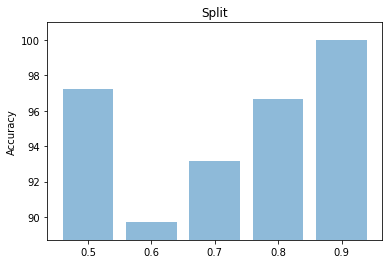

In [13]:
splits = [0.5, 0.6, 0.7, 0.8, 0.9]

results = []
for split in splits:
    X_train, Y_train, X_test, Y_test = load_dataset(data_file, 4, split)
    knn = kNN(X_train, Y_train)
    knn.test(X_test, Y_test)
    results.append(accuracy(knn.results))
    
objects = splits
y_pos = np.arange(len(objects))
performance = results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylim(min(performance)-1, max(performance)+1)
plt.ylabel('Accuracy')
plt.title('Split')
 
plt.show()

Class Index: 4
train set size:  120
test set size:  29


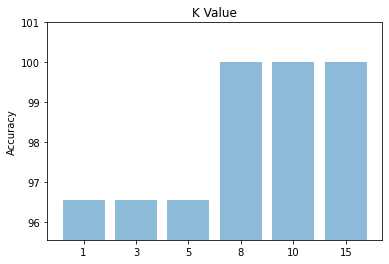

In [14]:
k_values = [1, 3, 5, 8, 10, 15]

results = []
X_train, Y_train, X_test, Y_test = load_dataset(data_file, 4, 0.8)
for k in k_values:
    knn = kNN(X_train, Y_train, k=k)
    knn.test(X_test, Y_test)
    results.append(accuracy(knn.results))
    
objects = k_values
y_pos = np.arange(len(objects))
performance = results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylim(min(performance)-1, max(performance)+1)
plt.ylabel('Accuracy')
plt.title('K Value')
 
plt.show()

Class Index: 4
train set size:  110
test set size:  39
94.87179487179486
94.87179487179486
41.02564102564102
41.02564102564102


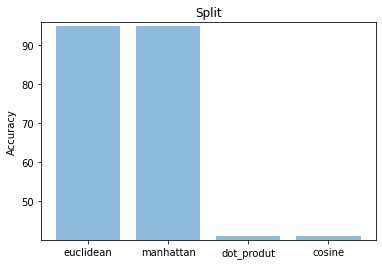

In [15]:
sims = [euclidean, manhattan, dot_product, cosine]

results = []
X_train, Y_train, X_test, Y_test = load_dataset(data_file, 4, 0.8)
for sim in sims:
    knn = kNN(X_train, Y_train, sim=sim)
    knn.test(X_test, Y_test)
    print(accuracy(knn.results))
    results.append(accuracy(knn.results))

objects = ['euclidean', 'manhattan', 'dot_produt', 'cosine']
y_pos = np.arange(len(objects))
performance = results
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylim(min(performance)-1, max(performance)+1)
plt.ylabel('Accuracy')
plt.title('Split')
 
plt.show()

In [16]:
#Load the dataset and maintain the features (X) and class labels (Y) separately  
# make sure you understand what the 4 and 0.8 default values are in the call
X_train, Y_train, X_test, Y_test = load_dataset(data_file, 4, 0.5)

Class Index: 4
train set size:  68
test set size:  81


In [17]:
print("Setup the kNN instances ...")
knn_list = []
ks = [1, 21, 51] # try a few different values for k
is_weighted = [False, True] # try two different forms of voting

# iterate over different voting strategies
for weighted in is_weighted:
    knn_list_element = [] # first set of knns with a specified voting scheme
    #iterate over different k values
    for k in ks:
        #create the different instances of the kNN class
        knn = kNN(X_train, Y_train, k, euclidean, weighted)
        
        knn_list_element.append(knn)
        pass
    
    knn_list.append(knn_list_element)# now append the set of models 
    pass


#lets test the kNNs 
#iterate through each model and accumilate number of correct predictions
knn_results = []
knn_result_element = []

for knn1 in knn_list:
    knn_result_element = []

    for knn2 in knn1:
        knn2.test(X_test, Y_test)
             
        knn_result_element.append(accuracy(knn2.results))
        
        pass
    pass
    knn_results.append(knn_result_element)
    pass
print("Results from trials...", knn_results)


Setup the kNN instances ...
Results from trials... [[92.5925925925926, 91.35802469135803, 79.01234567901234], [92.5925925925926, 91.35802469135803, 95.06172839506173]]


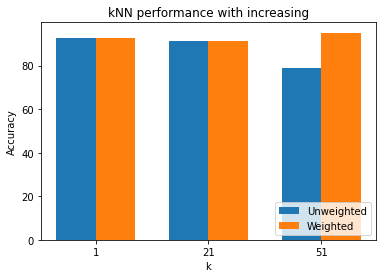

In [18]:
N = len(ks) # this is the number of results we want to plot pn the x-axis
ind = np.arange(N) 

performance1 = knn_results[0]
performance2 = knn_results[1]

width = 0.35 # width of the bar      
plt.bar(ind, performance1, width, label='Unweighted')
plt.bar(ind + width, performance2, width, label='Weighted')

plt.ylabel('Accuracy')
plt.xlabel('k')
plt.title('kNN performance with increasing')

plt.xticks(ind + width / 2, ks)
plt.legend(loc='lower right')
plt.show()

In [19]:
print("Setup the kNN instances ...")
knn_list = []
ks = [1, 3, 5, 10, 15, 20, 35, 50, 71] # try a few different values for k
is_weighted = [False, True] # try two different forms of voting

# iterate over different voting strategies
for weighted in is_weighted:
    knn_list_element = [] # first set of knns with a specified voting scheme
    #iterate over different k values
    for k in ks:
        #create the different instances of the kNN class
        knn = kNN(X_train, Y_train, k, euclidean, weighted)
        
        knn_list_element.append(knn)
        pass
    
    knn_list.append(knn_list_element)# now append the set of models 
    pass


#lets test the kNNs 
#iterate through each model and accumilate number of correct predictions
knn_results = []
knn_result_element = []

for knn1 in knn_list:
    knn_result_element = []

    for knn2 in knn1:
        knn2.test(X_test, Y_test)
             
        knn_result_element.append(accuracy(knn2.results))
        
        pass
    pass
    knn_results.append(knn_result_element)
    pass
print("Results from trials...", knn_results)

Setup the kNN instances ...
Results from trials... [[92.5925925925926, 95.06172839506173, 93.82716049382715, 97.53086419753086, 92.5925925925926, 92.5925925925926, 87.65432098765432, 79.01234567901234, 29.629629629629626], [92.5925925925926, 95.06172839506173, 93.82716049382715, 96.29629629629629, 93.82716049382715, 91.35802469135803, 90.12345679012346, 95.06172839506173, 95.06172839506173]]


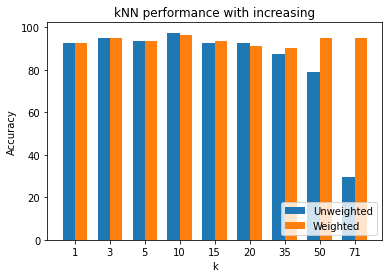

In [20]:
N = len(ks) # this is the number of results we want to plot pn the x-axis
ind = np.arange(N) 

performance1 = knn_results[0]
performance2 = knn_results[1]

width = 0.35 # width of the bar      
plt.bar(ind, performance1, width, label='Unweighted')
plt.bar(ind + width, performance2, width, label='Weighted')

plt.ylabel('Accuracy')
plt.xlabel('k')
plt.title('kNN performance with increasing')

plt.xticks(ind + width / 2, ks)
plt.legend(loc='lower right')
plt.show()

In [21]:
print("Setup the kNN instances ...")
knn_list = []
sims = [euclidean, manhattan, dot_product, cosine] 
is_weighted = [False, True] # try two different forms of voting

# iterate over different voting strategies
for weighted in is_weighted:
    knn_list_element = [] # first set of knns with a specified voting scheme
    #iterate over different k values
    for sim in sims:
        #create the different instances of the kNN class
        knn = kNN(X_train, Y_train, sim=sim, weighted=weighted)
        
        knn_list_element.append(knn)
        pass
    
    knn_list.append(knn_list_element)# now append the set of models 
    pass


#lets test the kNNs 
#iterate through each model and accumilate number of correct predictions
knn_results = []
knn_result_element = []

for knn1 in knn_list:
    knn_result_element = []

    for knn2 in knn1:
        knn2.test(X_test, Y_test)
             
        knn_result_element.append(accuracy(knn2.results))
        
        pass
    pass
    knn_results.append(knn_result_element)
    pass
print("Results from trials...", knn_results)


Setup the kNN instances ...
Results from trials... [[95.06172839506173, 92.5925925925926, 34.5679012345679, 34.5679012345679], [95.06172839506173, 92.5925925925926, 34.5679012345679, 34.5679012345679]]


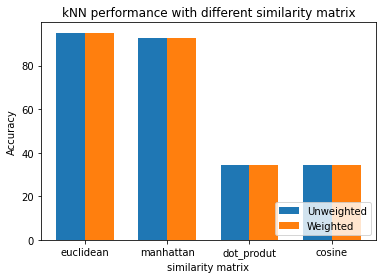

In [22]:
N = len(sims) # this is the number of results we want to plot pn the x-axis
ind = np.arange(N) 
objects = ['euclidean', 'manhattan', 'dot_produt', 'cosine']
performance1 = knn_results[0]
performance2 = knn_results[1]

width = 0.35 # width of the bar      
plt.bar(ind, performance1, width, label='Unweighted')
plt.bar(ind + width, performance2, width, label='Weighted')

plt.ylabel('Accuracy')
plt.xlabel('similarity matrix')
plt.title('kNN performance with different similarity matrix')

plt.xticks(ind + width / 2, objects)
plt.legend(loc='lower right')
plt.show()

In [23]:
train_file = "mnist_train.csv"
test_file = "mnist_test.csv"

#load the mnist training data CSV file into a list
#train_data_file = open("mnist/mnist_train_100.csv", 'r') # open and read the 100 instances in the text file
train_data_file = open(train_file, 'r')
train_data_list = train_data_file.readlines() # read all lines into memory 
train_data_file.close() 
print("train set size: ", len(train_data_list))

#testing the network
#load the mnist test data CSV file into a list
test_data_file = open(test_file, 'r') # read the file 
test_data_list = test_data_file.readlines()
test_data_file.close()
print("test set size: ", len(test_data_list))

# preprocess the data directly read from the csv file
# we want to maintain inputs (X) and targets (y) seperatly
def preprocess_data(Xy):
    X=[]
    y=[]
    for instance in Xy:
        # split the record by the ',' commas
        all_values = instance.split(',')
        # scale and shift the inputs
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values (all 0.01, except the desired label which is 0.99)
        targets = all_values[0]
        # all_values[0] is the target label for this record
        X.insert(len(X), inputs)
        #print(len(y), targets)
        y.insert(len(y), targets)
    pass
    return(X,y)
pass

train set size:  60000
test set size:  10000


In [24]:
# training_sizes = [100, 1000, 1500, 3000]
# results = []

# for tr_size in training_sizes:
#     mini_training_data = np.random.choice(train_data_list, tr_size, replace = False)
#     print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)

#     X_train, Y_train = preprocess_data(mini_training_data)
#     X_test, Y_test = preprocess_data(test_data_list)
#     knn = kNN(X_train, Y_train)
#     knn.test(X_test, Y_test)
#     print(accuracy(knn.results))
#     results.append(accuracy(knn.results))

In [25]:
# objects = training_sizes
# y_pos = np.arange(len(objects))
# performance = results
 
# plt.bar(y_pos, performance, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
# plt.ylim(min(performance)-1, max(performance)+1)
# plt.ylabel('Accuracy')
# plt.title('Split')
 
# plt.show()

In [26]:
# print("Setup the kNN instances ...")
# knn_list = []
# sims = [euclidean, manhattan, dot_product, cosine] 
# training_sizes = [5000, 10000, 20000, 60000]

# # iterate over different voting strategies
# for tr_size in training_sizes:
#     mini_training_data = np.random.choice(train_data_list, tr_size, replace = False)
#     print("Percentage of training data used:", (len(mini_training_data)/len(train_data_list)) * 100)

#     X_train, Y_train = preprocess_data(mini_training_data)
#     X_test, Y_test = preprocess_data(test_data_list)

#     knn_list_element = [] # first set of knns with a specified voting scheme
#     #iterate over different k values
#     for sim in sims:
#         #create the different instances of the kNN class
#         knn = kNN(X_train, Y_train, sim=sim, weighted=True)
        
#         knn_list_element.append(knn)
#         pass
    
#     knn_list.append(knn_list_element)# now append the set of models 
#     pass


# #lets test the kNNs 
# #iterate through each model and accumilate number of correct predictions
# knn_results = []
# knn_result_element = []

# for knn1 in knn_list:
#     knn_result_element = []

#     for knn2 in knn1:
#         knn2.test(X_test, Y_test)
             
#         knn_result_element.append(accuracy(knn2.results))
        
#         pass
#     pass
#     knn_results.append(knn_result_element)
#     pass
# print("Results from trials...", knn_results)

In [27]:
# N = len(sims) # this is the number of results we want to plot pn the x-axis
# ind = np.arange(N) 
# objects = ['euclidean', 'manhattan', 'dot_produt', 'cosine']
# performance0 = knn_results[0]
# performance1 = knn_results[1]
# performance2 = knn_results[2]
# performance3 = knn_results[3]

# width = 0.2 # width of the bar      
# plt.bar(ind, performance0, width, label='5000')
# plt.bar(ind + 1*width, performance1, width, label='10000')
# plt.bar(ind + 2*width, performance2, width, label='20000')
# plt.bar(ind + 3*width, performance3, width, label='60000')

# plt.ylabel('Accuracy')
# plt.xlabel('similarity matrix')
# plt.title('kNN performance with different similarity matrix')

# plt.xticks(ind+2*width , objects)
# plt.legend(loc='lower right')
# plt.show()

In [28]:
print("Setup the kNN instances ...")
knn_list = []
ks = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45] # try a few different values for k
is_weighted = [False, True] # try two different forms of voting

# iterate over different voting strategies
for weighted in is_weighted:
    knn_list_element = [] # first set of knns with a specified voting scheme
    #iterate over different k values
    for k in ks:
        #create the different instances of the kNN class
        knn = kNN(X_train, Y_train, k, euclidean, weighted)
        
        knn_list_element.append(knn)
        pass
    
    knn_list.append(knn_list_element)# now append the set of models 
    pass


#lets test the kNNs 
#iterate through each model and accumilate number of correct predictions
knn_results = []
knn_result_element = []

for knn1 in knn_list:
    knn_result_element = []

    for knn2 in knn1:
        knn2.test(X_test, Y_test)
        result = accuracy(knn2.results)
        knn_result_element.append(result)
        print("Appended:", result)
        pass
    pass
    knn_results.append(knn_result_element)
    print("Appended:",knn_result_element)
    pass
print("Results from trials...", knn_results)

Setup the kNN instances ...
Appended: 92.5925925925926
Appended: 93.82716049382715
Appended: 97.53086419753086
Appended: 92.5925925925926
Appended: 92.5925925925926
Appended: 91.35802469135803
Appended: 90.12345679012346
Appended: 87.65432098765432
Appended: 90.12345679012346
Appended: 80.24691358024691
Appended: [92.5925925925926, 93.82716049382715, 97.53086419753086, 92.5925925925926, 92.5925925925926, 91.35802469135803, 90.12345679012346, 87.65432098765432, 90.12345679012346, 80.24691358024691]
Appended: 92.5925925925926
Appended: 93.82716049382715
Appended: 96.29629629629629
Appended: 93.82716049382715
Appended: 91.35802469135803
Appended: 92.5925925925926
Appended: 92.5925925925926
Appended: 90.12345679012346
Appended: 92.5925925925926
Appended: 95.06172839506173
Appended: [92.5925925925926, 93.82716049382715, 96.29629629629629, 93.82716049382715, 91.35802469135803, 92.5925925925926, 92.5925925925926, 90.12345679012346, 92.5925925925926, 95.06172839506173]
Results from trials... [

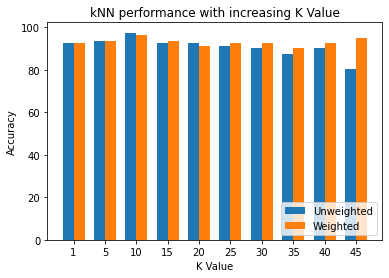

In [29]:
#Plot Results on a Bar Chart
N = len(ks) # this is the number of results we want to plot pn the x-axis
ind = np.arange(N) 

performance1 = knn_results[0]
performance2 = knn_results[1]

width = 0.35 # width of the bar      
plt.bar(ind, performance1, width, label='Unweighted')
plt.bar(ind + width, performance2, width, label='Weighted')

plt.ylabel('Accuracy')
plt.xlabel('K Value')
plt.title('kNN performance with increasing K Value')

plt.xticks(ind + width / 2, ks)
plt.legend(loc='lower right')
plt.show()